# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
from scipy.stats import binned_statistic
import astropy.units as u
import sys
import os
sys.path.append('/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/sage_output')
from sage import sage_class


# Defining hyper-parameters

In [2]:
main_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/AUMic_data/Formatted_TESS/'
input_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/Server_Runs/' 
output_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/Processed_Runs/'

runs_2_process = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8', 'Run9', 'Run10']

#Dictionary for the required arguments for the SAGE model for each run
fixed_args = {
    'Run1'        : {'spotnumber': 2, 
                    'var_param_list': [r'spot1_lat', r'spot2_lat', r'spot1_long',r'spot2_long', r'spot1_size', r'spot2_size', 'offset', 'jitter', 'Prot'],
                    'fix_param_list':['C$_{sp}$'],'fix_param_values':[0.2]},
    
    'Run2-2'      : {'spotnumber': 3,  
                    'var_param_list': [r'spot1_lat', r'spot2_lat', r'spot3_lat', r'spot1_long',r'spot2_long',r'spot3_long', r'spot1_size', r'spot2_size',r'spot3_size', 'offset', 'jitter', 'Prot'],
                    'fix_param_list':['C$_{sp}$'], 'fix_param_values':[0.2]},
    
    'Run3-3'      : {'spotnumber': 2,
                    'var_param_list': [r'spot1_lat', r'spot2_lat', r'spot1_long',r'spot2_long', 'offset', 'jitter', 'Prot', r'sp_ctrst'],
                    'fix_param_list':[r'spot1_size', r'spot2_size'], 'fix_param_values':[15, 25]},
    
    'Run4'        : {'spotnumber': 2, 
                    'var_param_list': [r'spot1_lat', r'spot2_lat', r'spot1_long',r'spot2_long', r'spot1_size', r'spot2_size', 'offset', 'jitter', 'Prot'],
                    'fix_param_list':['C$_{sp}$'], 'fix_param_values':[0.5]},
    
    'Run5-fullrot': {'spotnumber': 2, 
                    'var_param_list': [r'spot1_lat', r'spot2_lat', r'spot1_long',r'spot2_long', r'spot1_size', r'spot2_size', 'offset', 'jitter', 'Prot'],
                    'fix_param_list':['C$_{sp}$'], 'fix_param_values':[0.2]},
    
    # 'Run6'        : {'spotnumber': 2, 
    #                 'var_param_list': [r'spot1_lat', r'spot2_lat', r'spot1_long',r'spot2_long', r'spot1_size', r'spot2_size', 'offset', 'jitter', 'Prot'],
    #                 'fix_param_list':['C$_{sp}$'], 'fix_param_values':[0.2]},
}
runs_2_process = list(fixed_args.keys())

#Defining dictionary with planet information -> to remove their transits
planet_propdic = {}
planet_propdic['AUMicb']={}
planet_propdic['AUMicb']['T0'] = 2458330.39051 #BJD
planet_propdic['AUMicb']['period'] = 8.463000  #days
planet_propdic['AUMicb']['T14'] = 3.4927/24    #days
planet_propdic['AUMicc']={}
planet_propdic['AUMicc']['T0'] = 2458342.2240 #BJD
planet_propdic['AUMicc']['period'] = 18.85969  #days
planet_propdic['AUMicc']['T14'] = 4.236/24    #days
planet_list = list(planet_propdic.keys())

#Defining the flare sigma-clipping thresholds
#% For analysis of individual LCs
sigma_dic = {1:[1.5, 2.5], 27:[1.5, 1.5]}
#% For analysis of concatenated LCs
# sigma_dic = {1:[2.5], 27:[1.5]}

#Defining number of points to bin each LC to
nbins = 500

#Ditctionary for the over-arching process steps
process_steps = {}

#Over-arching toggle for the process steps
process_steps['proc'] = False
#Basic MCMC post-processing 
#   - burning chains
#   - sigma-clipping chains
process_steps['basic_MCMC'] = True
process_steps['nburn'] = 3000
process_steps['trace_sig_clip'] = 2.5
#Plotting the walkers traces
process_steps['plot_trace'] = True
#Plotting the corner plot
process_steps['plot_corner'] = True
#Plotting the best-fit model & residuals
process_steps['best_fit'] = True
#Calculating auto-correlation time
process_steps['auto_correlation'] = True

# Important functions

In [3]:
def eval_sage(params, time, args):
    # disintegrating the params to make it usable in sage. 
    #% Spots
    spot_long= []
    spot_lat=[]
    spot_size= []
    for spot_param, spot_list in zip(['lat', 'long', 'size'], [spot_lat, spot_long, spot_size]):
        for num in range(args['spotnumber']):
            param_name = f'spot{num+1}_{spot_param}'
            if param_name in args['var_param_list']:spot_list.append(params[args['var_param_list'].index(param_name)])
            elif param_name in args['fix_param_list']:spot_list.append(args['fix_param_values'][args['fix_param_list'].index(param_name)])

    #% All others
    add_param_values = {'offset': 0.,'jitter': 0.,'Prot': 0.,'sp_ctrst': 0.}

    # Update values from args
    for key in add_param_values:
        if key in args['var_param_list']:
            add_param_values[key] = params[args['var_param_list'].index(key)]
        elif key in args['fix_param_list']:
            add_param_values[key] = args['fix_param_values'][args['fix_param_list'].index(key)]

    # Extract final values
    offset = add_param_values['offset']
    jitt = add_param_values['jitter']
    prot = add_param_values['Prot']
    spotcontrast = add_param_values['sp_ctrst']

    # inclination= params[-1] # inclination of star
    inclination=90.

    # defining wavelength params
    wavelength= [5000]  # cal wavelength [pretty much useless]
    flux_hot=[1]        # immaculate photosphere
    flux_cold= [1 * spotcontrast]   #[0.2691] # contrast
    
    u1= 0.63
    u2= 0.15

    stellar_params=[0.0488,                                    # Radius-ratio   
                18.79,                                     # scaled semi-major axis 
                u1,                                        # U1
                u2,                                        # U2
                0.0,                                       # cosine of angular distance
                0.0,                                       # Intensity profile 
                inclination]                               

    planet_pixel_size= 10

    ve=(2*np.pi*0.744*696340)/(prot*24*3600)

    model_lightcurve = np.empty(len(time))

    for i, ti in enumerate(time):
        
        phase_roti = ((2*np.pi)/prot) * (ti - time[0])

        star = sage_class(stellar_params, planet_pixel_size, wavelength, flux_hot, flux_cold, 
                spot_lat, spot_long, spot_size, ve, args['spotnumber'], 'multi-color', 5000, phases_rot=[np.rad2deg(phase_roti) * u.deg])

        flux_norm, _, _= star.rotate_star()

        model_lightcurve[i] = flux_norm 

    return model_lightcurve + offset, jitt

# Defining rolling median function
def rolling_median(data, window):
    half_window = window // 2
    medians = np.full_like(data, np.nan)
    for i in range(half_window, len(data) - half_window):
        medians[i] = np.median(data[i - half_window:i + half_window + 1])
    return medians

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

# Processing

Skipping the SAGE post-processing as process_steps['proc'] is set to False.
Plotting RMS values across all runs...
Run with smallest RMS for Secxtor 1, LC 1: Run2-2
Run with smallest RMS for Sector 1, LC 2: Run5-fullrot
Run with smallest RMS for Sector 2, LC 1: Run2-2
Run with smallest RMS for Sector 2, LC 2: Run1


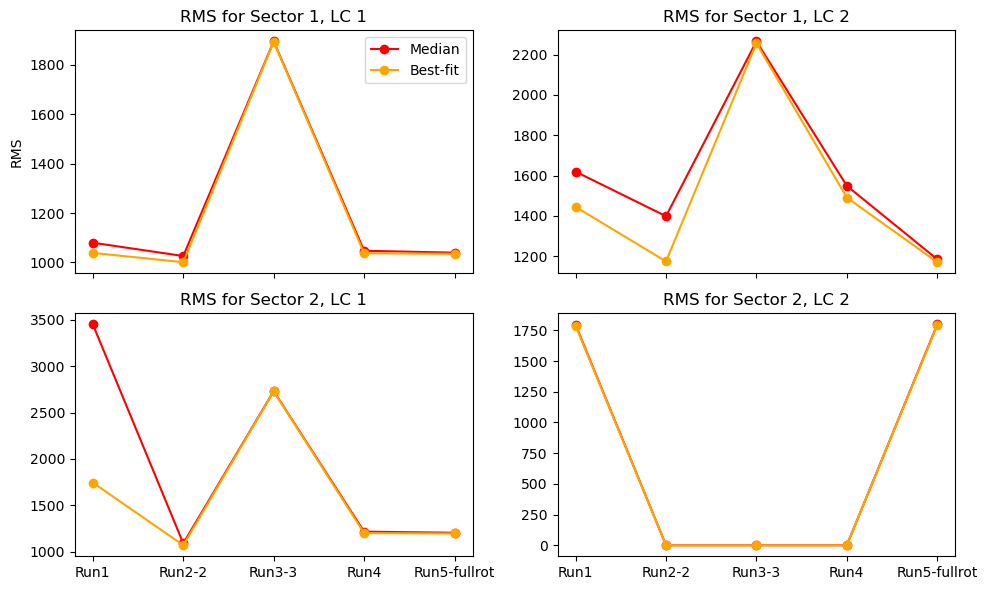

In [13]:
if process_steps['proc']:
    print("Starting the SAGE post-processing...")
    #Storing the RMS values of each run
    rms_median_values = np.zeros((len(runs_2_process),2,2), dtype=float)
    rms_logprob_values = np.zeros((len(runs_2_process),2,2), dtype=float)

    # Checking that all the directories exist - if not, raise an error or make the directory
    for imp_dir in [main_dir, input_dir]:
        if not os.path.exists(imp_dir):raise FileNotFoundError(f"The directory {imp_dir} does not exist. Please check the path.")
    if not os.path.exists(output_dir):os.makedirs(output_dir)

    #Iterating over the runs to process
    for irun, run in enumerate(runs_2_process):
        run_input_dir = input_dir+run
        run_output_dir = output_dir+run

        # Checking that the input directory exists for the run
        if not os.path.exists(run_input_dir):
            raise FileNotFoundError(f"The input directory for {run} does not exist: {run_input_dir}")
        
        # Creating the output directory for the run if it does not exist
        if not os.path.exists(run_output_dir):os.makedirs(run_output_dir)
        if '.DS_Store' in os.listdir(run_input_dir):os.remove(run_input_dir + '/.DS_Store')
        
        # Retrieving the arguments for this run
        run_args = fixed_args[run]
        print(f"Processing {run}...")

        #Iterating over the TESS sectors
        for isect, TESS_sect in enumerate(os.listdir(run_input_dir)):
            sect_num = TESS_sect.split('_')[1]
            print(f"    Processing TESS sector {sect_num}...")
            sect_input_dir = run_input_dir + '/' + TESS_sect
            sect_output_dir = run_output_dir + '/' + TESS_sect
            if not os.path.exists(sect_output_dir):os.makedirs(sect_output_dir)
            if '.DS_Store' in os.listdir(sect_input_dir):os.remove(sect_input_dir + '/.DS_Store')

            #Iterating over LCs for each sector
            for LC_idx, LC in enumerate(os.listdir(sect_input_dir)):
                LC_num = LC.split('_')[1]
                print(f"        Processing LC {LC_num}...")
                LC_input_dir = sect_input_dir + '/' + LC
                LC_output_dir = sect_output_dir + '/' + LC
                if not os.path.exists(LC_output_dir):os.makedirs(LC_output_dir)

                # 1. Basic MCMC post-processing
                if process_steps['basic_MCMC']:
                    print("            BASIC MCMC POST-PROCESSING")


                    #1.1 Importing the chains
                    # Checking if the directory contains the necessary files
                    if not os.path.exists(LC_input_dir + '/chains.npy'):
                        print(f"The chains.npy file does not exist in {LC_input_dir}. Please check the path.")
                        continue
                    else:raw_chains = np.load(LC_input_dir + '/chains.npy')
                    if not os.path.exists(LC_input_dir + '/logprob.npy'):
                        print(f"The logprob.npy file does not exist in {LC_input_dir}. Please check the path.")
                        continue
                    else:log_prob = np.load(LC_input_dir + '/logprob.npy')

                    # Retrieving shapes
                    nwalkers, nsteps, ndim = raw_chains.shape
                    
                    #1.2 Sigma-clipping the chains
                    del_chain = []
                    for ipar, param in enumerate(run_args['var_param_list']):
                        param_median = np.median(raw_chains[:,process_steps['nburn']:,ipar])
                        param_std = np.std(raw_chains[:,process_steps['nburn']:,ipar])
                        for iwalk in range(nwalkers):
                            if (np.abs(raw_chains[iwalk, -1, ipar] - param_median) > process_steps['trace_sig_clip']*param_std):del_chain.append(iwalk)
                    del_chain = np.unique(del_chain)
                    print(f"            Removing {len(del_chain)} walkers from the chain due to large deviations.")
                    if len(del_chain) > 0:
                        sigclip_chains = np.delete(raw_chains, del_chain, axis=0)
                    else:sigclip_chains = np.copy(raw_chains)

                    #1.3 Burning the chains
                    burnt_chains = sigclip_chains[:,process_steps['nburn']:, :]

                    #1.4 Saving the processed chains in the output directory
                    np.save(LC_output_dir+'/burnt_chains.npy', burnt_chains)

                #2. Plotting the walkers traces
                if process_steps['plot_trace']:
                    print('            PLOTTING: TRACE')
                    #% Plot
                    _, axes = plt.subplots(ndim, 1, figsize=(10, 2*ndim), sharex=True)
                    for i, param in enumerate(run_args['var_param_list']):
                        ax = axes[i]
                        ax.axhline(np.median(raw_chains[:,  process_steps['nburn']:, i]), linestyle='--', color='black', zorder=2)
                        for w in range(nwalkers):
                            if w in del_chain:ax.plot(np.arange(nsteps), raw_chains[w, :, i], color='red', alpha=0.5, lw=0.7, zorder=1)
                            else:
                                ax.plot(np.arange(process_steps['nburn']), raw_chains[w, :process_steps['nburn'], i], color='red', alpha=0.5, lw=0.7, zorder=1)
                                ax.plot(np.arange(process_steps['nburn'], nsteps), raw_chains[w, process_steps['nburn']:, i], color='blue', alpha=0.5, lw=0.7, zorder=1)
                        ax.set_ylabel(param)
                    axes[-1].set_xlabel("Step")
                    plt.tight_layout()
                    plt.savefig(LC_output_dir+'/trace.pdf')
                    plt.close()

                #3. Plotting the corner plot
                if process_steps['plot_corner']:
                    print('            PLOTTING: CORNER')
                    #% Plot
                    fig1 = corner.corner(
                        burnt_chains,
                        labels=run_args['var_param_list'],
                        show_titles=True,
                        title_kwargs={"fontsize": 10},
                        label_kwargs={"fontsize": 10},
                        title_fmt=".6f",
                    )
                    axes = np.array(fig1.axes).reshape((ndim, ndim))
                    plt.savefig(LC_output_dir+'/corner.pdf')
                    plt.close()

                #4. Plotting best-fit model and residuals
                if process_steps['best_fit']:
                    print("            BEST-FIT PLOTTING")

                    #4.1 Retrieving the raw data
                    raw_LC_data = pd.read_csv(main_dir + f'Sector_{sect_num}/LC_{sect_num}_{LC_num}.csv')
                    #Masking nans and infinited fluxes
                    mask_finite_flux = (np.isfinite(raw_LC_data['flux']) & ~np.isnan(raw_LC_data['flux']))
                    raw_t = raw_LC_data['time'][mask_finite_flux] + 2457000 #converting TESS BJD to BJD
                    raw_flux = raw_LC_data['flux'][mask_finite_flux]
                    raw_flux_err = raw_LC_data['flux_err'][mask_finite_flux]

                    #4.2 Formatting the raw data (i.e. removing transits and flares) to show what was fit
                    #Removing transit of planet considered   
                    print('            REMOVING TRANSIT')
                    #% Defining mask to figure out the timestamps of in-transit exposures
                    IT_mask = np.zeros(len(raw_t), dtype=bool)

                    #% Looping over all known planets in the system just in case
                    for planet in planet_list:
                        #% Getting planet properties 
                        planet_dic = planet_propdic[planet]

                        #% Number of transits that happened during epoch considered
                        n_low  = np.round((min(raw_t) - planet_dic['T0'])/planet_dic['period'], 0)
                        n_high = np.round((max(raw_t) - planet_dic['T0'])/planet_dic['period'], 0)
                        #% Predicting transit midpoints during epoch considered
                        predicted_T0s = planet_dic['T0'] + np.arange(n_low, n_high+1, 1)*planet_dic['period']

                        #%Looping over all transits in epoch considered and updating mask to remove them
                        for predicted_T0 in predicted_T0s:
                            IT_mask |= (raw_t>predicted_T0-(planet_dic['T14']/2)) & (raw_t<predicted_T0+(planet_dic['T14']/2))

                    #Masking the transits
                    format_t = np.copy(raw_t[~IT_mask])
                    format_flux = np.copy(raw_flux[~IT_mask])
                    format_flux_err = np.copy(raw_flux_err[~IT_mask])

                    #Removing flares
                    print('            REMOVING FLARES')

                    #% compute rolling median of the LC
                    rolling_med = rolling_median(format_flux, window=300)

                    #% "Normalize" LC
                    raw_norm_flux = format_flux/rolling_med
                    norm_flux = raw_norm_flux[~np.isnan(raw_norm_flux)]

                    #% Sigma clip to remove flares
                    sigma=sigma_dic[int(sect_num)][LC_idx]
                    flare_mask = ((raw_norm_flux < np.median(norm_flux) - sigma*np.std(norm_flux)) | (raw_norm_flux > np.median(norm_flux) + sigma*np.std(norm_flux)))

                    #Masking points
                    format_t=format_t[~flare_mask]
                    format_flux=format_flux[~flare_mask]
                    format_flux_err=format_flux_err[~flare_mask]


                    #Binning data to make MCMC easier
                    print('            BINNING DATA')
                    binned_t = binned_statistic(format_t, format_t, statistic='mean', bins=nbins)[0]
                    binned_flux = binned_statistic(format_t, format_flux, statistic='mean', bins=nbins)[0]
                    binned_flux_err = binned_statistic(format_t, format_flux_err, statistic='std', bins=nbins)[0]

                    #Final cleaned result
                    binned_flux = binned_flux[~np.isnan(binned_t)]
                    binned_flux_err = binned_flux_err[~np.isnan(binned_t)]
                    binned_t = binned_t[~np.isnan(binned_t)]

                    #4.3 Retrieving best-fit model (median and highest log-probability)
                    median_params = np.median(burnt_chains, axis=(0,1))
                    median_model = eval_sage(median_params, binned_t, run_args)[0]
                    rms_median = np.std(binned_flux - median_model)* 1e6
                    rms_median_values[irun, isect, LC_idx] = rms_median 

                    max_step, max_walker = np.unravel_index(np.argmax(log_prob), log_prob.shape)
                    highest_logprob_params = raw_chains[max_walker, max_step, :]
                    highest_logprob_model = eval_sage(highest_logprob_params, binned_t, run_args)[0]
                    rms_highest_logprob = np.std(binned_flux - highest_logprob_model)* 1e6
                    rms_logprob_values[irun, isect, LC_idx] = rms_highest_logprob
                    #4.4 Plotting
                    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=[14, 4])

                    ax1.errorbar(binned_t, binned_flux, yerr=binned_flux_err, fmt='.', color='blue', label='Data', alpha=0.5)
                    ax1.plot(binned_t, highest_logprob_model, color='orange', label=f'Highest log-probability, RMS={rms_highest_logprob:.4f} ppm')
                    ax1.plot(binned_t, median_model, color='red', label=f'Median Model, RMS={rms_median:.4f} ppm')

                    ax2.errorbar(binned_t, (binned_flux - highest_logprob_model), yerr=binned_flux_err, fmt='.', color='orange')
                    ax2.errorbar(binned_t, (binned_flux - median_model), yerr=binned_flux_err, fmt='.', color='red')
                    ax1.set_ylabel("Flux")
                    ax2.set_xlabel("Time (BJD)")
                    ax2.set_ylabel("Residuals")
                    ax1.legend()
                    plt.tight_layout()
                    plt.savefig(LC_output_dir+'/best_fit.pdf')
                    plt.close()

                #5. Calculate the autocorrelation time
                if process_steps['auto_correlation']:
                    print("            AUTOCORRELATION TIME")

                    N = np.exp(np.linspace(np.log(100), np.log(nsteps), 10)).astype(int)
                    fig, axes = plt.subplots(4, 3, figsize=(16, 20), sharex=True)
                    axs = axes.ravel()
                    nrows, ncols = 4, 3
                    for ipar, param in enumerate(run_args['var_param_list']):                    
                        ax = axs[ipar]

                        # Compute the estimators for a few different chain lengths
                        gw2010 = np.empty(len(N))
                        new = np.empty(len(N))
                        param_chain = raw_chains[:, :, ipar]
                        for i, n in enumerate(N):
                            gw2010[i] = autocorr_gw2010(param_chain[:, :n])
                            new[i] = autocorr_new(param_chain[:, :n])

                        # Plot the comparisons
                        ax.loglog(N, gw2010, "g.", linestyle='-', label="G&W 2010")
                        ax.loglog(N, new, "r.", linestyle='-',  label="new")
                        ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
                        ax.set_ylim([min(min(gw2010),min(new)), max(max(gw2010),max(new))])
                        ax.set_ylabel(rf"$\tau$ estimates for {param}")
                        
                        # Only set xlabel if in last row used
                        if ipar // ncols == (ndim - 1) // ncols:
                            ax.set_xlabel("number of samples, $N$")

                        # Only include legend once
                        if ipar == 0:
                            ax.legend(fontsize=14)

                    # Remove any unused subplots
                    for j in range(ndim, nrows * ncols):
                        fig.delaxes(axs[j])

                    fig.tight_layout()
                    plt.savefig(LC_output_dir+'/ACF.pdf')
                    plt.close()

    np.save(output_dir + '/rms_median_values.npy', rms_median_values)
    np.save(output_dir + '/rms_logprob_values.npy', rms_logprob_values)

else:
    print("Skipping the SAGE post-processing as process_steps['proc'] is set to False.")
    rms_median_values = np.load(output_dir + '/rms_median_values.npy')
    rms_logprob_values = np.load(output_dir + '/rms_logprob_values.npy')

#6. Plotting the RMS values across all the runs
print("Plotting RMS values across all runs...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10, 6))

ax1.plot(runs_2_process, rms_median_values[:, 0, 0], marker='o', color='red', label='Median')
ax1.plot(runs_2_process, rms_logprob_values[:, 0, 0], marker='o', color='orange', label='Best-fit')

ax2.plot(runs_2_process, rms_median_values[:, 0, 1], marker='o', color='red')
ax2.plot(runs_2_process, rms_logprob_values[:, 0, 1], marker='o', color='orange')

ax3.plot(runs_2_process, rms_median_values[:, 1, 0], marker='o', color='red')
ax3.plot(runs_2_process, rms_logprob_values[:, 1, 0], marker='o', color='orange')

ax4.plot(runs_2_process, rms_median_values[:, 1, 1], marker='o', color='red')
ax4.plot(runs_2_process, rms_logprob_values[:, 1, 1], marker='o', color='orange')

ax1.set_title("RMS for Sector 1, LC 1")
ax2.set_title("RMS for Sector 1, LC 2")
ax3.set_title("RMS for Sector 2, LC 1")
ax4.set_title("RMS for Sector 2, LC 2")
ax1.legend()
ax1.set_xticks(runs_2_process)
ax1.set_ylabel("RMS")
plt.tight_layout()
plt.savefig(output_dir+'/RMS_plot.pdf')
plt.plot()

print('Run with smallest RMS for Secxtor 1, LC 1:', runs_2_process[np.argmin(rms_logprob_values[:, 0, 0])])
print('Run with smallest RMS for Sector 1, LC 2:', runs_2_process[np.argmin(rms_logprob_values[:, 0, 1])])
print('Run with smallest RMS for Sector 2, LC 1:', runs_2_process[np.argmin(rms_logprob_values[:, 1, 0])])
sector2_lc2_rms = rms_logprob_values[:, 1, 1]
nonzero_mask = sector2_lc2_rms != 0.
valid_indices = np.where(nonzero_mask)[0]

if len(valid_indices) > 0:
    best_index = valid_indices[np.argmin(sector2_lc2_rms[nonzero_mask])]
    print('Run with smallest RMS for Sector 2, LC 2:', runs_2_process[best_index])
